<h1>Ion Switching Advanced EDA and Prediction</h1>

<img src="https://storage.googleapis.com/kaggle-media/competitions/Liverpool/ion%20image.jpg"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

Ion channels are pore-forming membrane proteins that allow ions to pass through the channel pore. Their functions include establishing a resting membrane potential, shaping action potentials and other electrical signals by gating the flow of ions across the cell membrane, controlling the flow of ions across secretory and epithelial cells, and regulating cell volume. Ion channels are present in the membranes of all excitable cells.

When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research.

The University of Liverpool’s Institute of Ageing and Chronic Disease is working to advance ion channel research. Their team of scientists have asked for Kagglers help. In this competition, we use ion channel data to better model automatic identification methods. 

The data in train and test are actually batches of 50,000 values, sampled at 0.1 ms, i.e. a total of 50 sec./batch, totally 100 batches in train and 40 batches in test.


# <a id='2'>Prepare the data analysis</a>  

## Include packages

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import time
import math
from numba import jit
from math import log, floor
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
from sklearn.neighbors import KDTree
from pathlib import Path
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error, f1_score

## Read the data

In [2]:
DATA_PATH = "../input/liverpool-ion-switching"

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# <a id='3'>Data exploration</a>  


## Glimpse the data

In [3]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (5000000, 3)
Test data: (2000000, 2)


In [4]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [5]:
test_df.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [6]:
train_df.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


In [7]:
test_df.describe()

,time,signal
count,2.000000e+06,2.000000e+06
mean,6.000001e+02,-4.259114e-02
std,5.773504e+01,2.505120e+00
min,5.000001e+02,-5.509600e+00
25%,5.500001e+02,-2.470600e+00
50%,6.000000e+02,-3.551000e-01
75%,6.500000e+02,1.783400e+00
max,7.000000e+02,1.081000e+01


The signals are sampled at 0.1 ms time intervals.   
In **train** there are 5M sample data (from 0 to 500 s) and in **test** there are 2M sample data (from 500 to 700 s).  
There are 100 batches of 5 s in train and 40 batches of 5 sec. in test.

## Data plots

We will look now in detail to the signals in both train and test data.

In [8]:
def plot_time_data(data_df, title="Time variation data", color='b'):
    plt.figure(figsize=(18,8))
    plt.plot(data_df["time"], data_df["signal"], color=color)
    plt.title(title, fontsize=24)
    plt.xlabel("Time [sec]", fontsize=20)
    plt.ylabel("Signal", fontsize=20)
    plt.show()

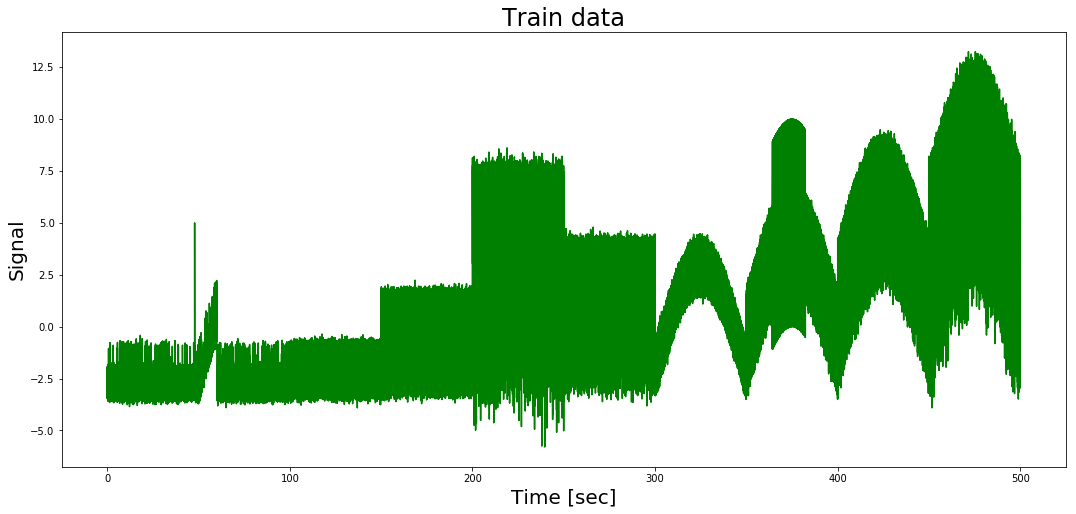

In [9]:
plot_time_data(train_df,"Train data",'g')

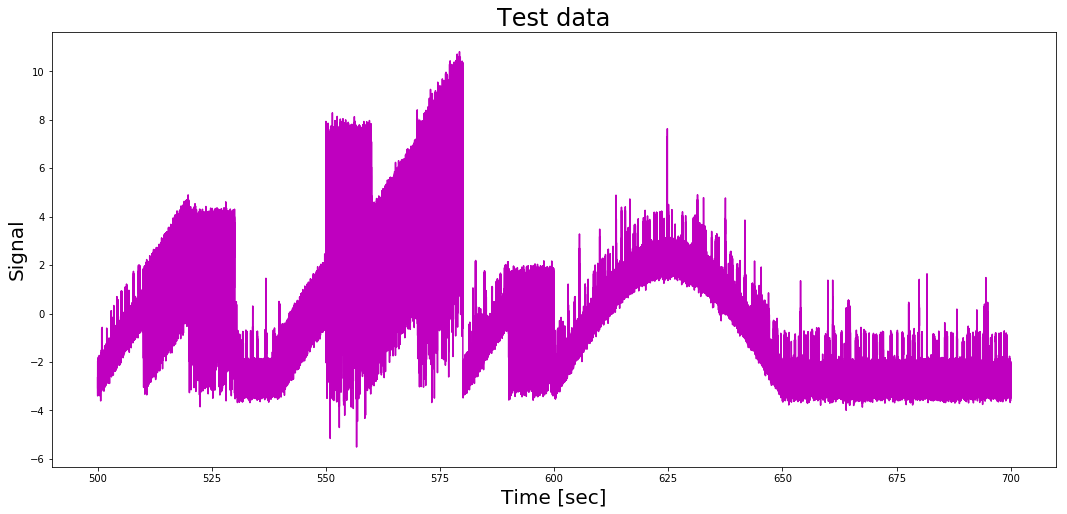

In [10]:
plot_time_data(test_df,"Test data",'m')

For more visibility, we can show samples of data. We will use time intervals of 50 ms.

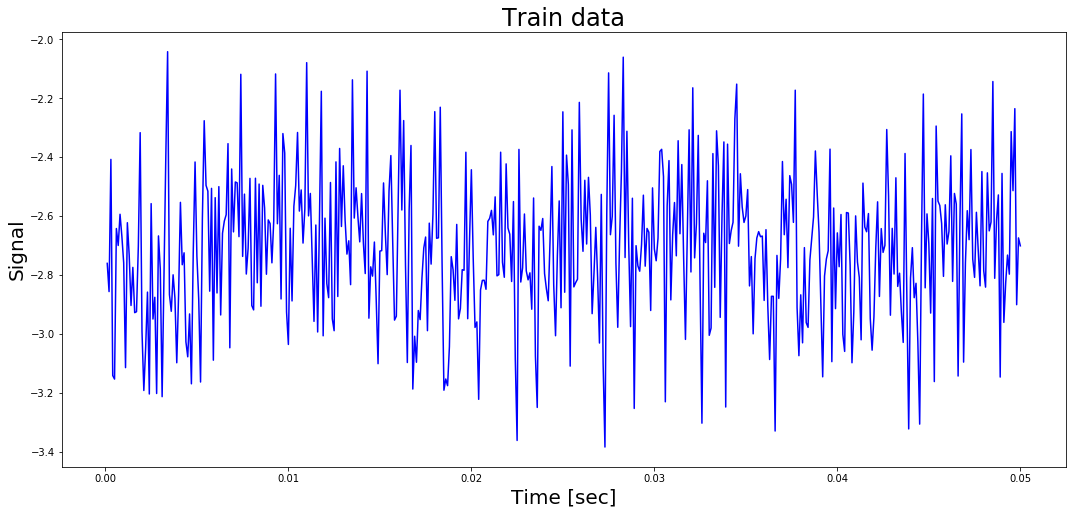

In [11]:
plot_time_data(train_df[0:500],"Train data",'b')

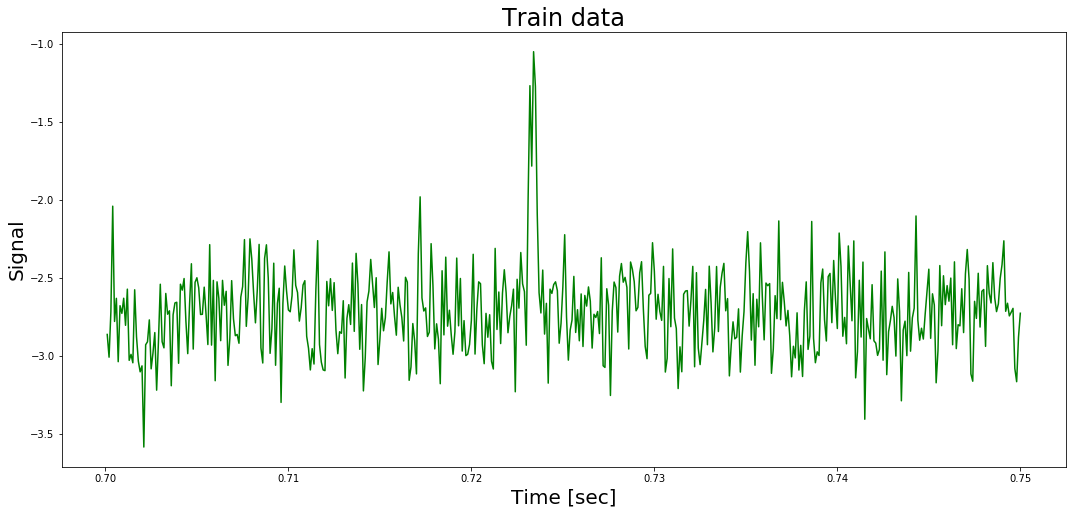

In [12]:
plot_time_data(train_df[7000:7500],"Train data",'g')

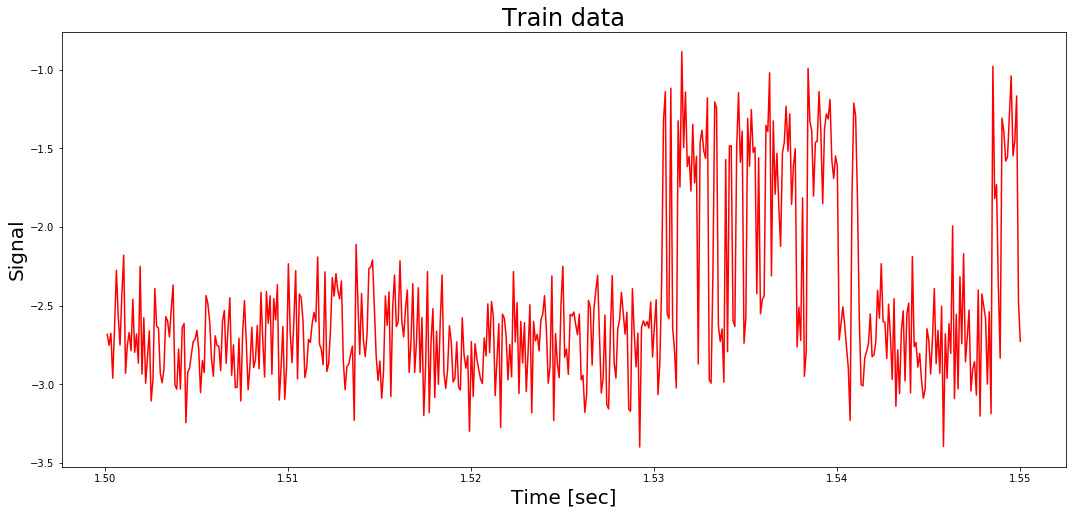

In [13]:
plot_time_data(train_df[15000:15500],"Train data",'r')

We will show now both signal and channel signal on the same graph.

In [14]:
def plot_time_channel_data(data_df, title="Time variation data"):
    plt.figure(figsize=(18,8))
    plt.plot(data_df["time"], data_df["signal"], color='b', label='Signal')
    plt.plot(data_df["time"], data_df["open_channels"], color='r', label='Open channel')
    plt.title(title, fontsize=24)
    plt.xlabel("Time [sec]", fontsize=20)
    plt.ylabel("Signal & Open channel data", fontsize=20)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

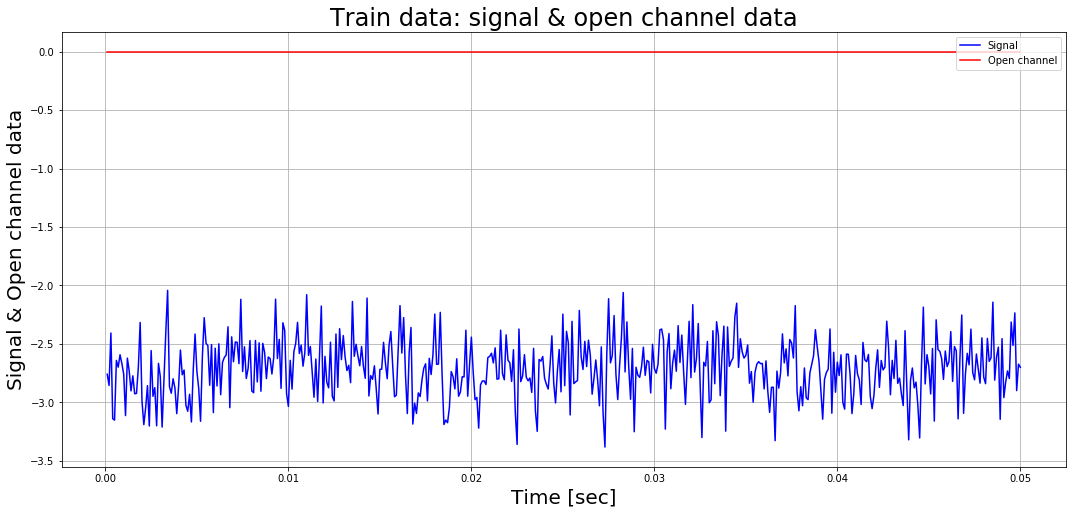

In [15]:
plot_time_channel_data(train_df[0:500],'Train data: signal & open channel data')

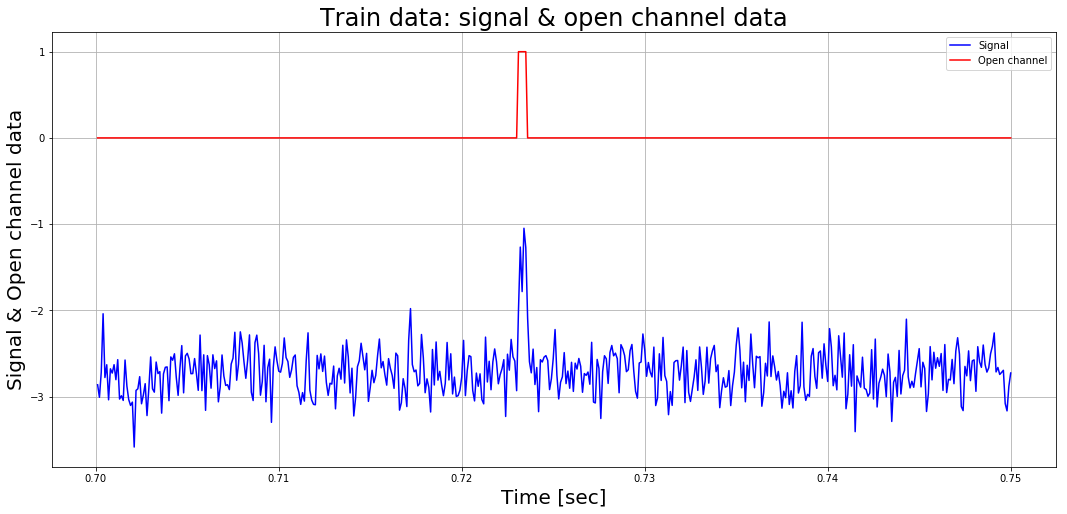

In [16]:
plot_time_channel_data(train_df[7000:7500],'Train data: signal & open channel data')

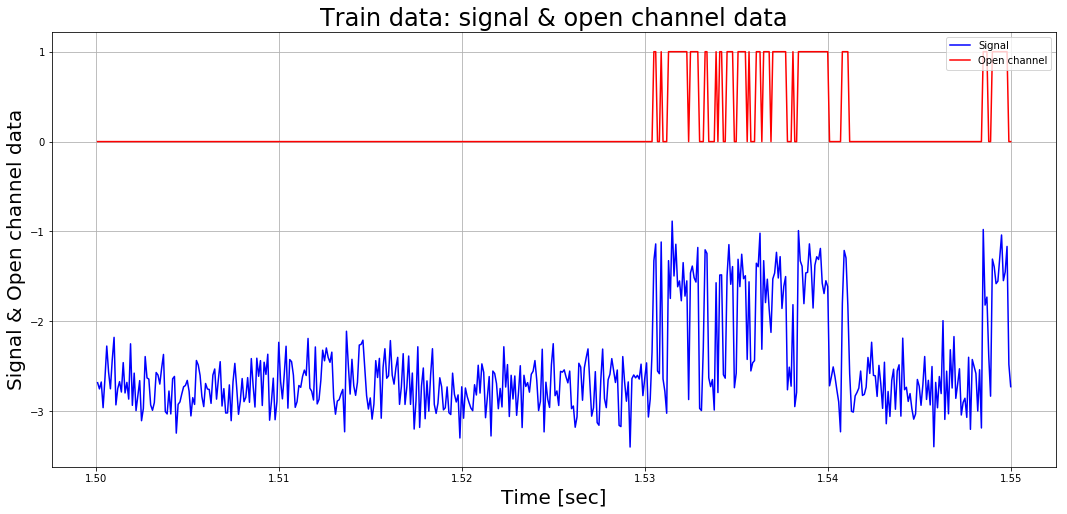

In [17]:
plot_time_channel_data(train_df[15000:15500],'Train data: signal & open channel data')

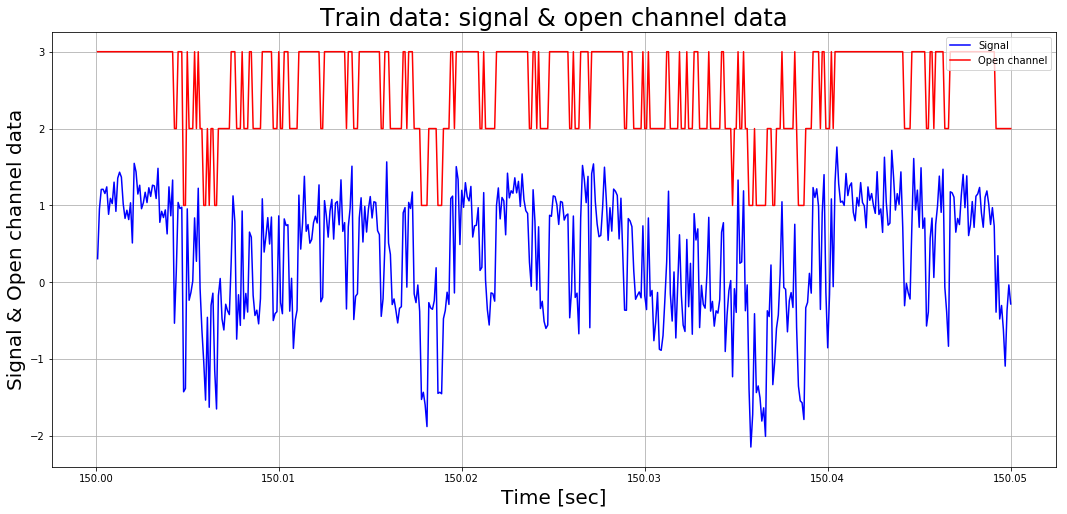

In [18]:
plot_time_channel_data(train_df[1500000:1500500],'Train data: signal & open channel data')

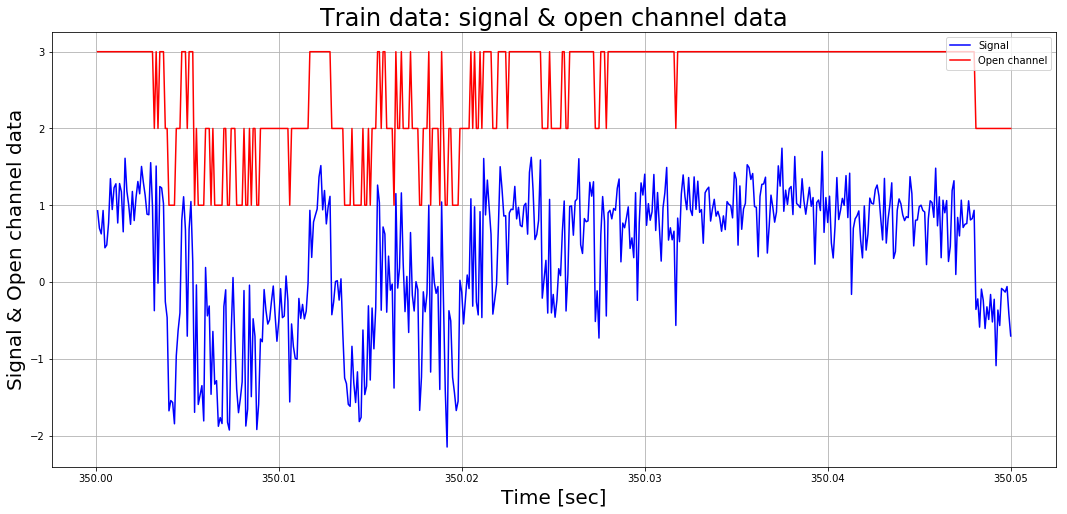

In [19]:
plot_time_channel_data(train_df[3500000:3500500],'Train data: signal & open channel data')

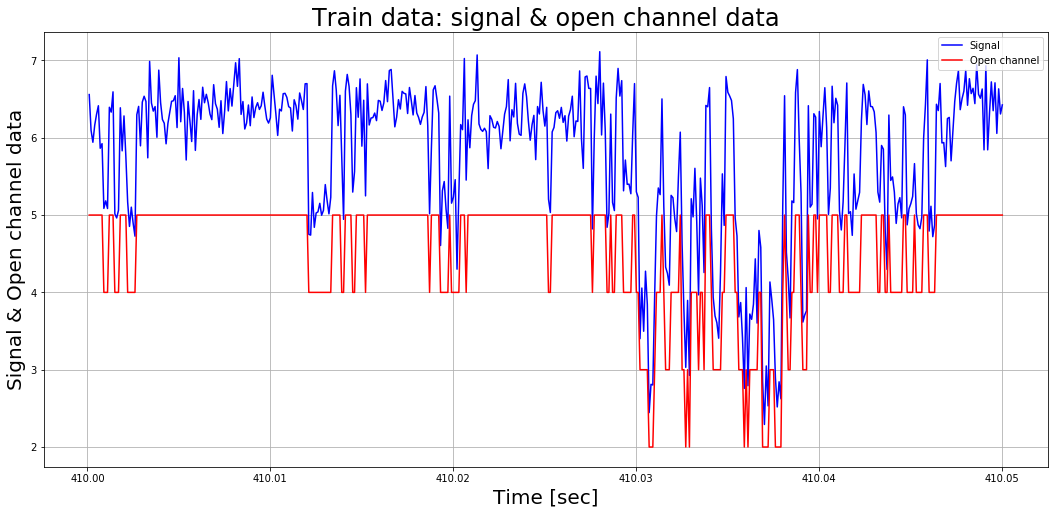

In [20]:
plot_time_channel_data(train_df[4100000:4100500],'Train data: signal & open channel data')

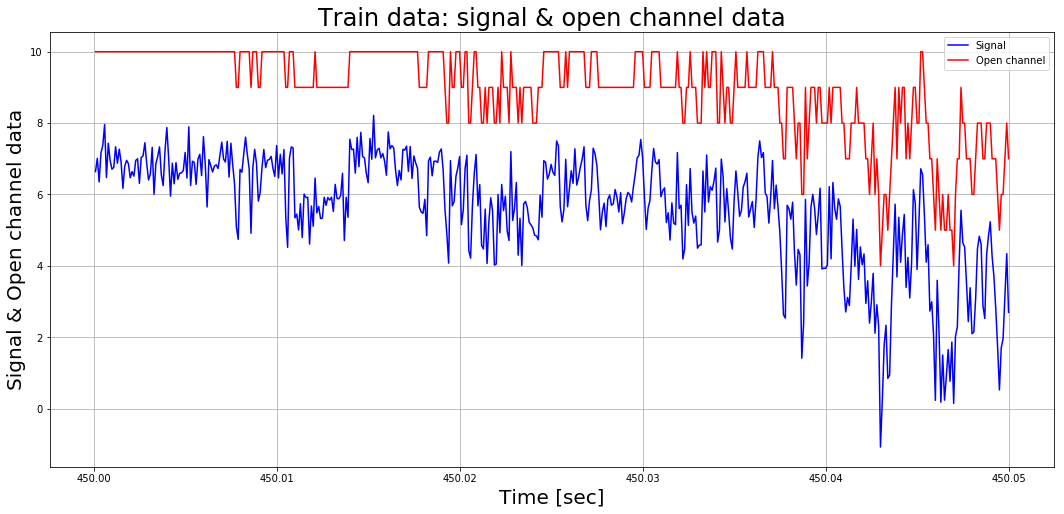

In [21]:
plot_time_channel_data(train_df[4500000:4500500],'Train data: signal & open channel data')

Let's look to the open channels distribution only.

In [22]:
def plot_open_channel_count(data_df, title):
    plt.figure(figsize=(8,6))
    sns.countplot(data_df['open_channels'])
    plt.title(title)
    plt.show()

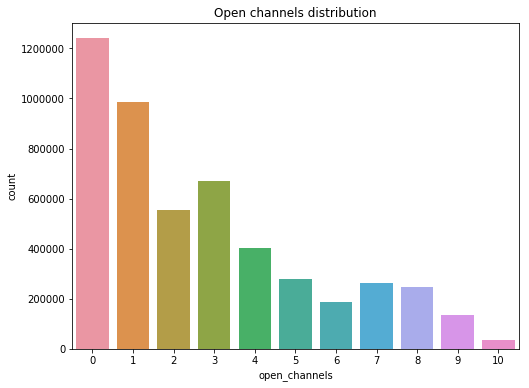

In [23]:
plot_open_channel_count(train_df,'Open channels distribution')

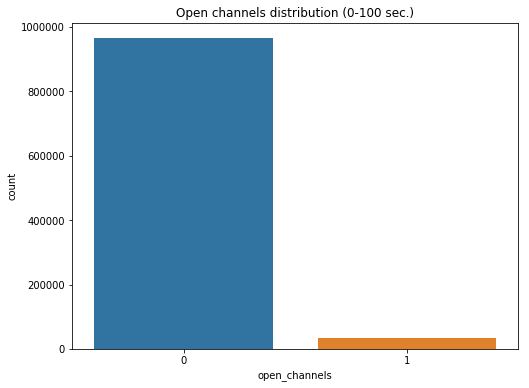

In [24]:
plot_open_channel_count(train_df[0:1000000],'Open channels distribution (0-100 sec.)')

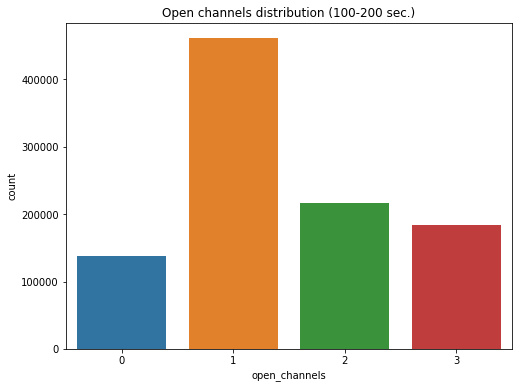

In [25]:
plot_open_channel_count(train_df[1000000:2000000],'Open channels distribution (100-200 sec.)')

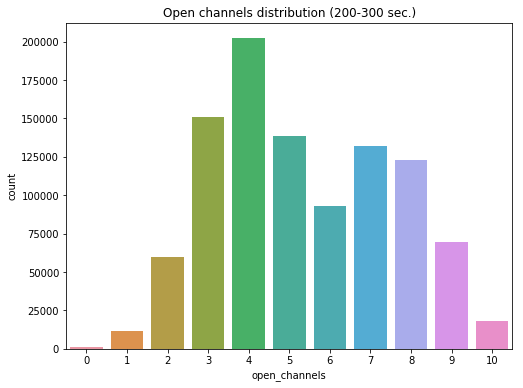

In [26]:
plot_open_channel_count(train_df[2000000:3000000],'Open channels distribution (200-300 sec.)')

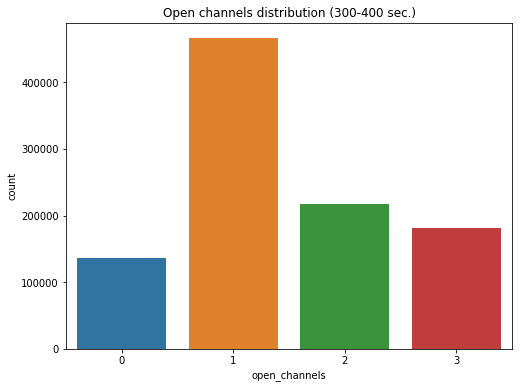

In [27]:
plot_open_channel_count(train_df[3000000:4000000],'Open channels distribution (300-400 sec.)')

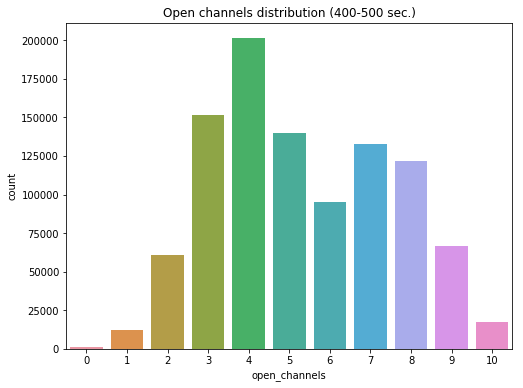

In [28]:
plot_open_channel_count(train_df[4000000:5000000],'Open channels distribution (400-500 sec.)')

# <a id='4'>Feature engineering</a>  

In [29]:
train_df['train'] = True
test_df['train'] = False
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_data['train'] = all_data['train'].astype('bool')

all_data = all_data.sort_values(by=['time']).reset_index(drop=True)
all_data.index = ((all_data.time * 10_000) - 1).values
all_data['batch'] = all_data.index // 50_000
all_data['batch_index'] = all_data.index  - (all_data.batch * 50_000)
all_data['batch_slices'] = all_data['batch_index']  // 5_000
all_data['batch_slices2'] = all_data.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)

# 50_000 Batch Features
all_data['signal_batch_min'] = all_data.groupby('batch')['signal'].transform('min')
all_data['signal_batch_max'] = all_data.groupby('batch')['signal'].transform('max')
all_data['signal_batch_std'] = all_data.groupby('batch')['signal'].transform('std')
all_data['signal_batch_mean'] = all_data.groupby('batch')['signal'].transform('mean')
all_data['signal_batch_median'] = all_data.groupby('batch')['signal'].transform('median')
all_data['signal_batch_mad'] = all_data.groupby('batch')['signal'].transform('mad')
all_data['signal_batch_skew'] = all_data.groupby('batch')['signal'].transform('skew')
all_data['mean_abs_chg_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.mean(np.abs(np.diff(x))))
all_data['abs_max_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.max(np.abs(x)))
all_data['abs_min_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.min(np.abs(x)))

all_data['range_batch'] = all_data['signal_batch_max'] - all_data['signal_batch_min']
all_data['maxtomin_batch'] = all_data['signal_batch_max'] / all_data['signal_batch_min']
all_data['abs_avg_batch'] = (all_data['abs_min_batch'] + all_data['abs_max_batch']) / 2

In [30]:
for c in ['signal_batch_min','signal_batch_max','signal_batch_std','signal_batch_mean',
          'signal_batch_median', 'signal_batch_mad', 'signal_batch_skew',
          'mean_abs_chg_batch','abs_max_batch','abs_min_batch',
          'range_batch','maxtomin_batch','abs_avg_batch']:
    all_data[f'{c}_msignal'] = all_data[c] - all_data['signal']

In [31]:
FEATURES = [f for f in all_data.columns if f not in ['open_channels','index','time','train','batch',
                                               'batch_index','batch_slices','batch_slices2']]
print('....: FEATURE LIST :....')
print([f for f in FEATURES])


....: FEATURE LIST :....
['signal', 'signal_batch_min', 'signal_batch_max', 'signal_batch_std', 'signal_batch_mean', 'signal_batch_median', 'signal_batch_mad', 'signal_batch_skew', 'mean_abs_chg_batch', 'abs_max_batch', 'abs_min_batch', 'range_batch', 'maxtomin_batch', 'abs_avg_batch', 'signal_batch_min_msignal', 'signal_batch_max_msignal', 'signal_batch_std_msignal', 'signal_batch_mean_msignal', 'signal_batch_median_msignal', 'signal_batch_mad_msignal', 'signal_batch_skew_msignal', 'mean_abs_chg_batch_msignal', 'abs_max_batch_msignal', 'abs_min_batch_msignal', 'range_batch_msignal', 'maxtomin_batch_msignal', 'abs_avg_batch_msignal']


# <a id='5'>Model</a>  

In [32]:
TARGET = 'open_channels'

TOTAL_FOLDS = 3

MODEL_TYPE = 'LGBM'
SHUFFLE = True
NUM_BOOST_ROUND = 10_000
EARLY_STOPPING_ROUNDS = 50
RANDOM_SEED = 314


all_data['train'] = all_data['train'].astype('bool')
train_df = all_data.query('train').copy()
test_df = all_data.query('not train').copy()
train_df['open_channels'] = train_df['open_channels'].astype(int)
X = train_df[FEATURES]
X_test = test_df[FEATURES]
y = train_df[TARGET].values
sub = test_df[['time']].copy()
groups = train_df['batch']

params = {'learning_rate': 0.01,
          'max_depth': -1,
          'num_leaves': 2**8+1,
          'feature_fraction': 1,
          'bagging_fraction': 1,
          'bagging_freq': 0,
          'n_jobs': 8,
          'seed': 314,
          'metric': 'rmse',
          'objective' : 'regression',
          'num_class': 1
        }

kfold = KFold(n_splits=TOTAL_FOLDS, shuffle=True, random_state=314)

oof_df = train_df[['signal','open_channels']].copy()
fi_df = pd.DataFrame(index=FEATURES)

fold = 1 
for tr_idx, val_idx in kfold.split(X, y, groups=groups):
    print(f'====== Fold {fold:0.0f} of {TOTAL_FOLDS} ======')
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    train_set = lgb.Dataset(X_tr, y_tr)
    val_set = lgb.Dataset(X_val, y_val)

    model = lgb.train(params,
                      train_set,
                      num_boost_round = NUM_BOOST_ROUND,
                      early_stopping_rounds = EARLY_STOPPING_ROUNDS,
                      valid_sets = [train_set, val_set],
                      verbose_eval = 50)

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    test_preds = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds = np.round(np.clip(test_preds, 0, 10)).astype(int)

    oof_df.loc[oof_df.iloc[val_idx].index, 'oof'] = preds
    sub[f'open_channels_fold{fold}'] = test_preds

    f1 = f1_score(oof_df.loc[oof_df.iloc[val_idx].index]['open_channels'],
                  oof_df.loc[oof_df.iloc[val_idx].index]['oof'],
                            average = 'macro')
    rmse = np.sqrt(mean_squared_error(oof_df.loc[oof_df.index.isin(val_idx)]['open_channels'],
                                      oof_df.loc[oof_df.index.isin(val_idx)]['oof']))

    fi_df[f'importance_{fold}'] = model.feature_importance()
    print(f'Fold {fold} - validation f1: {f1:0.5f}')
    print(f'Fold {fold} - validation rmse: {rmse:0.5f}')

    fold += 1

oof_f1 = f1_score(oof_df['open_channels'],
                    oof_df['oof'],
                    average = 'macro')
oof_rmse = np.sqrt(mean_squared_error(oof_df['open_channels'],
                                      oof_df['oof']))


====== Fold 1 of 3 ======
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.62307	valid_1's rmse: 1.62335
[100]	training's rmse: 0.99925	valid_1's rmse: 0.999567
[150]	training's rmse: 0.631979	valid_1's rmse: 0.632375
[200]	training's rmse: 0.424158	valid_1's rmse: 0.424685
[250]	training's rmse: 0.315391	valid_1's rmse: 0.316075
[300]	training's rmse: 0.264501	valid_1's rmse: 0.265322
[350]	training's rmse: 0.243127	valid_1's rmse: 0.244063
[400]	training's rmse: 0.234733	valid_1's rmse: 0.235768
[450]	training's rmse: 0.231516	valid_1's rmse: 0.232642
[500]	training's rmse: 0.230266	valid_1's rmse: 0.231479
[550]	training's rmse: 0.229749	valid_1's rmse: 0.231045
[600]	training's rmse: 0.229506	valid_1's rmse: 0.230883
[650]	training's rmse: 0.229367	valid_1's rmse: 0.230821
[700]	training's rmse: 0.229271	valid_1's rmse: 0.230799
[750]	training's rmse: 0.229194	valid_1's rmse: 0.230796
[800]	training's rmse: 0.229127	valid_1's rmse: 0.230798
Early

# <a id='6'>Submission</a>  

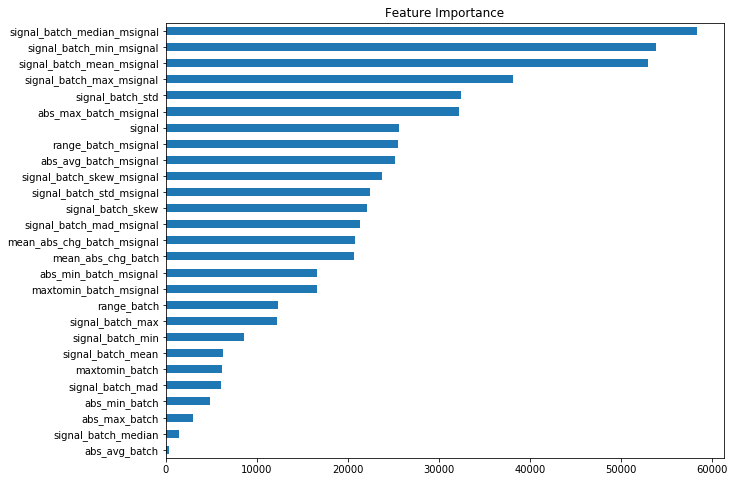

In [33]:
s_cols = [s for s in sub.columns if 'open_channels' in s]

sub['open_channels'] = sub[s_cols].median(axis=1).astype(int)
sub[['time','open_channels']].to_csv('./submission.csv',
        index=False,
        float_format='%0.4f')

fi_df['importance'] = fi_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(10,8))
fi_df.sort_values('importance')['importance'] \
    .plot(kind='barh',
          figsize=(10,8),
          title=f'Feature Importance',
         ax=ax)

# <a id='7'>References</a>  

[1] University of Liverpool - Ion Switching, Identify the number of channels open at each time point, Competition introduction, https://www.kaggle.com/c/liverpool-ion-switching  
[2] Ion channel, Wikipedia article, https://en.wikipedia.org/wiki/Ion_channel